# Session 9. Classification: Logistic Regression, SVM

## The Logistic Classifier

Regression techniques are typically used for predicting the real-valued output. But what if the output is discrete and even binary - 0 and 1 - i.e. what if we are dealing with a binary classification problem based on the real-valued input variables? 

Consider a training sample of size $N$ for a binary output variable 
$${\displaystyle y = }
\left\{ \begin{array}{l l} 
{1} & \quad \text{event happened }\\ 
{0} & \quad \text{event not happened } \\
\end{array} \right.
$$
and $n$ regressors $x^j$: 
$$
X=\{x_i, i=1..N\}=\{x_i^j, i=1..N, j=1..n\},\ Y=\{y_i, i=1..N\}.
$$ 

Instead of trying to predict the spefic value of $y$, we admit its uncertainty considering it a binary random variable, trying to predict its probability distribution (Bernoulli as the only meaningfull one for a binary variable):

$$
P(y|x)=Bern(y|\mu(x))
$$

depending on the parameter $\mu$ being a function of $x$ to determine. A simplest suggestion for $\mu$ would be a linear model (incorporating intercept as a slope coefficient for an additional dummy variable if needed):

$$
\mu(x)=x\cdot\beta,
$$

however as $\mu=P(y=1)$ is the probability, it can only take values between 0 to 1, while there is no good way to ensure that the linear form $x\beta$ takes value within this interval. This could be corrected by considering 
$$
\mu(x)=f(x\cdot\beta),
$$
where $f$ is a certain function taking values only between 0 and 1. As for this function $f$, one can select a sigmoid function
$$
f(x)=\sigma(x)=\frac{e^x}{1+e^x}=\frac{1}{1+e^{-x}}.
$$
Sigmoid function always takes values within the interval $(0,1)$. This way 

$$
\displaystyle P(y=1) = \sigma(x\beta)=\frac{e^{x\beta}}{1+e^{x\beta}}=\frac{1}{1+e^{-x\beta}}
$$$$
\displaystyle P(y=0) = 1-P(y=1)=\frac{1}{1+e^{x\beta}}
$$

Then the likelihood of getting observed values of the output variable $y_i$ corresponding to the inputs $x_i$ can be defined as
$$
L=\prod\limits_i P(y=y_i|x_i,\beta),
$$
while log-likelihood is
$$
log(L)=\sum\limits_i log\left(P(y=y_i|x_i,\beta)\right)=\sum\limits_i y_i log\left(P(y=1|x_i,\beta)\right)+
\sum\limits_i (1-y_i)log\left(P(y=0|x_i,\beta)\right)=
$$$$
-\sum\limits_i log\left(1+exp((2 y_i-1)x_i\beta)\right).
$$
Then
$$
\beta=argmin_{\beta} \sum\limits_i log\left(1+exp((2 y_i-1)x_i\beta)\right).
$$
The above optimization problem can no longer be solved in the closed analytic form, but instead a multivariate iterational numerical optimization heuristics, such as various gradient decent methods, could be applied. 

In [1]:
#import all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import preprocessing
import urllib
%pylab inline

# To ignore some warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

/Users/devashishkhulbe/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


Populating the interactive namespace from numpy and matplotlib


In [2]:
#set colormap
pylab.rcParams['image.cmap'] = 'RdYlGn'

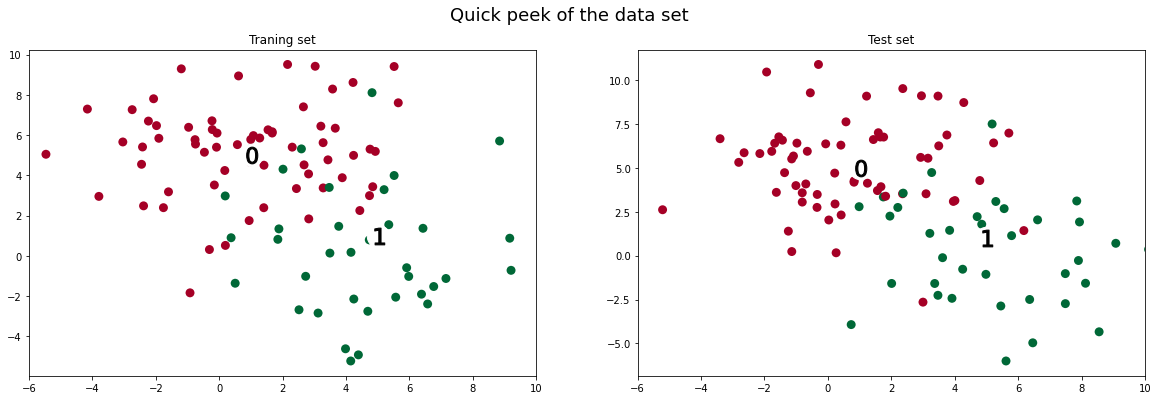

In [3]:
# generate some random 2d data points around two centroid points (1,5) and (5,1)
# classified based on which of the centroids was used, (1,5) label 0 and (5,1) with label 1
n = 100
random.seed(2016)
label = np.random.binomial(1, 0.4, size = 2*n)  # Bernoulli is binomial with n = 1
x1 = np.array([1,5])[label] + np.random.normal(0, 2.5, size = 2*n)
x2 = np.array([5,1])[label] + np.random.normal(0, 2.5, size = 2*n)

#visualization
fig1 = plt.figure(figsize = (20,6))
plt.suptitle("Quick peek of the data set", fontsize = 18)
ax1, ax2 = fig1.add_subplot(121), fig1.add_subplot(122)
ax1.scatter(x1[:n], x2[:n], lw = 0, s = 80, c = label[:n])
ax2.scatter(x1[n:], x2[n:], lw = 0, s = 80, c = label[n:])
ax1.set(title = 'Traning set', xlim = [-6,10])
ax2.set(title = 'Test set', xlim = [-6,10])

ax1.scatter([1,5], [5,1], marker='o', c="w", s=500)
ax2.scatter([1,5], [5,1], marker='o', c="w", s=500)
for i, c in enumerate([1,5]):
    ax1.scatter(c, 6-c, marker='$%d$'%i, s=280, color = 'k')
    ax2.scatter(c, 6-c, marker='$%d$'%i, s=280, color = 'k')

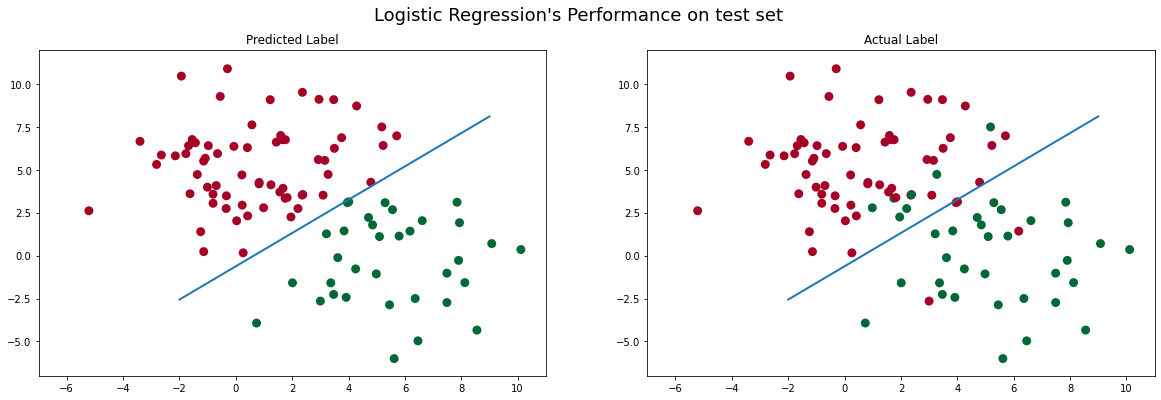

Accuracy=0.89


In [4]:
#learn logistic regression over the training sample
logit = LogisticRegression()
# C is an inverse regularization constant. More detail when we consider Bayesian inference, 
# for now lets just mention that higher C mean no regularization
X_train=np.c_[x1[:n], x2[:n]]
X_test=np.c_[x1[n:], x2[n:]]
Y_train=label[:n]
logit.fit(X_train,Y_train)

#apply to the validation sample
labelPred = logit.predict(X_test)
labelActual = label[n:]

#visualize the actual and learned classification
fig2 = plt.figure(figsize = (20,6))
plt.suptitle("Logistic Regression's Performance on test set", fontsize = 18)
ax1, ax2 = fig2.add_subplot(121), fig2.add_subplot(122)

#show decision boundary on both plots
xplot = np.linspace(-2,9,200)
yplot = -(logit.intercept_[0] + logit.coef_[0][0]*xplot)/logit.coef_[0][1]
ax1.plot(xplot,yplot,lw = 2)
ax2.plot(xplot,yplot,lw = 2)

ax1.set(title='Predicted Label', xlim = [-7,11], ylim = [-7,12])
ax2.set(title='Actual Label', xlim = [-7,11], ylim = [-7,12])
ax1.scatter(x1[n:], x2[n:], lw = 0, s = 80, c = labelPred)
ax2.scatter(x1[n:], x2[n:], lw = 0, s = 80, c = labelActual)
plt.show()
correct=1.0*(labelPred==labelActual).sum()/len(labelPred)
print('Accuracy={}'.format(correct))

Accuracy=0.91


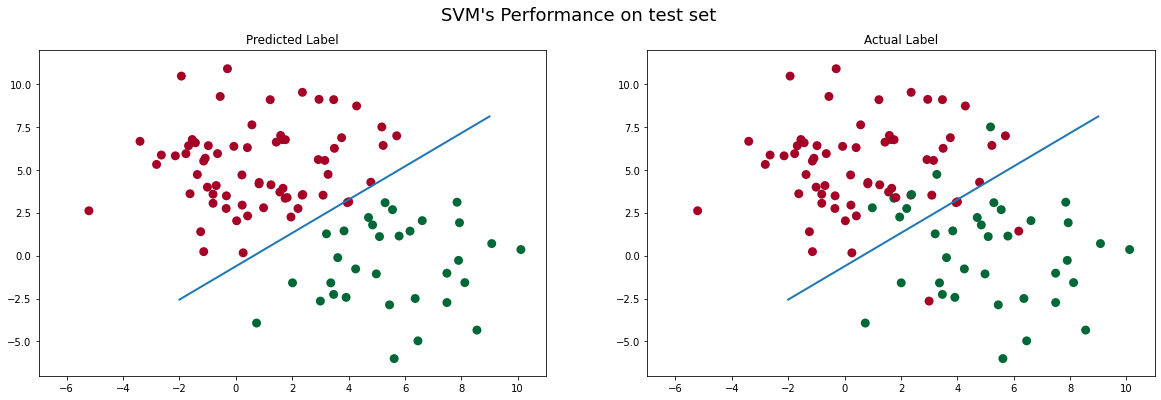

In [5]:
#redo the same classification with Support Vector Machines (SVM)
#SVM is a different classifier briefly introduced in the overview lecture
clf = svm.SVC(kernel='linear')
clf.fit(X_train, Y_train)
labelPred=clf.predict(X_test)
correct=1.0*(labelPred==labelActual).sum()/len(labelPred)
print('Accuracy={}'.format(correct))

fig2 = plt.figure(figsize = (20,6))
plt.suptitle("SVM's Performance on test set", fontsize = 18)
ax1, ax2 = fig2.add_subplot(121), fig2.add_subplot(122)
#decision boundary
xplot = np.linspace(-2,9,200)
yplot = -(logit.intercept_[0] + logit.coef_[0][0]*xplot)/logit.coef_[0][1]
ax1.plot(xplot,yplot,lw = 2)
ax2.plot(xplot,yplot,lw = 2)

ax1.set(title='Predicted Label', xlim = [-7,11], ylim = [-7,12])
ax2.set(title='Actual Label', xlim = [-7,11], ylim = [-7,12])
ax1.scatter(x1[n:], x2[n:], lw = 0, s = 80, c = labelPred)
ax2.scatter(x1[n:], x2[n:], lw = 0, s = 80, c = labelActual)
plt.show()

In [6]:
#logistic regression can also give certainty (probability) for each label in the classification
logitProbability = logit.predict_proba(X_test)[:,1]
logitProbability[0:10]

array([5.20382561e-01, 1.09958309e-02, 3.99327474e-02, 9.92534462e-01,
       1.66062548e-01, 2.11370100e-01, 3.49565389e-01, 3.11225005e-03,
       5.39324811e-04, 2.45317493e-02])

In [7]:
# This is how predicted label was created
logitProbability[0:10]>0.5

array([ True, False, False,  True, False, False, False, False, False,
       False])

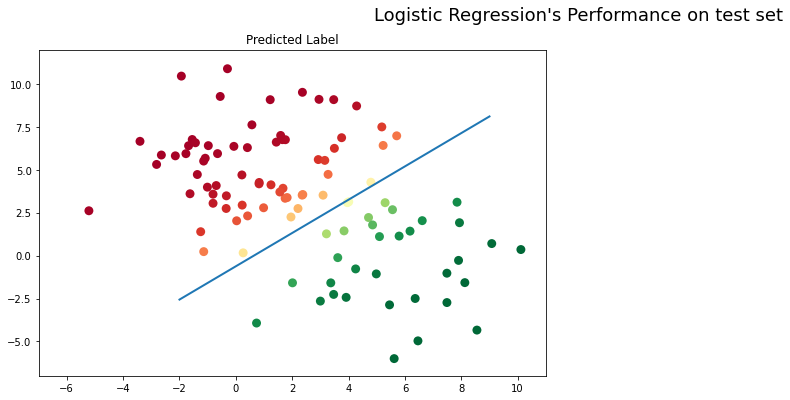

In [8]:
#visualize the prediction label probabilities 
fig2 = plt.figure(figsize = (20,6))
plt.suptitle("Logistic Regression's Performance on test set", fontsize = 18)
ax1 = fig2.add_subplot(121)

#decision boundary
ax1.plot(xplot,yplot,lw = 2)
ax2.plot(xplot,yplot,lw = 2)

ax1.set(title='Predicted Label', xlim = [-7,11], ylim = [-7,12])
ax1.scatter(x1[n:], x2[n:], lw = 0, s = 80, c = logitProbability)
plt.show()

## Confusion matrix

Fit of the binary classifier over the selected test set can be characterized by the confusion matrix
$$
\left[\begin{array}{c|c}TP&FN\\
\hline
FP&TN\end{array}\right]
$$
with
* $TP$ - number of true positives (correctly classified positives ($y_i=1$)), 
* $FP$ - number of false positives (observed negatives ($y_i=0$) incorrectly classified as positives ($y_i=1$)), 
* $FN$ - number of false negatives (observed positives ($y_i=1$) incorrectly classified as negatives ($y_i=0$)), 
* $TN$ - number of true negatives (correctly classified negatives ($y_i=0$)).

In relative terms the following quantities are often considered:

* Precision or positive predictive value (fraction of true positive classifications among all actual positive observations):
$$
PPV=\frac{TP}{TP+FP},
$$
* Sensitivity or recall or true positive rate (fraction of true positives among all positive classifications):
$$
TPR=\frac{TP}{TP+FN},
$$
* Accuracy (fraction of true classifications among all instances considered)
$$
ACC=\frac{TP+TN}{TP+TN+FP+FN}.
$$

In [9]:
def print_confusion_matrix(predictions, labels):
    # Function for printing Confusion matrix, based on labels and predictions
    ls = list(confusion_matrix(predictions, labels)) ## returns tn, fp, fn, tp
    ls = pd.DataFrame(ls, columns = ['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
    print ("Confusion Matrix:\n", ls)
    
print_confusion_matrix(labelPred, labelActual)

Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                  61                   7
Actual Positive                   2                  30


In [10]:
#compute TP,FP,FN,TN for the above classification
TP = sum((labelPred==1)&(labelActual==1))
FP = sum((labelPred==1)&(labelActual==0))
FN = sum((labelPred==0)&(labelActual==1))
TN = sum((labelPred==0)&(labelActual==0))

#compute precision, accuracy and recall
Acc = 100.0 * (TP+TN)/(TP+TN+FP+FN)
Rec = 100.0 * TP/(TP+FN)
Prec= 100.0 * TP/(TP+FP)
print('Precision = %.2f%%\nAccuracy = %.2f%%\nRecall = %.2f%%'%(Prec,Acc,Rec))

Precision = 93.75%
Accuracy = 91.00%
Recall = 81.08%


All three performance metrics are quite high, indicating our model's good performance, thanks to the separability of the data

## Multiclass classification. Iris dataset with sklearn

Logistic Regression from sklearn could equally well handle a multiclass classification

In [11]:
# import classic Iris data
iris = datasets.load_iris()
X = iris.data
Y = iris.target
print (iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [12]:
X[0:10,:]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [13]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
#train logistic regression based on first two features
logreg = LogisticRegression()
logreg.fit(X[:,:2], Y)
Z = logreg.predict(X[:,:2])

In [15]:
Z

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1])

In [16]:
#in case of multi-class classification Logistic regression provides probabilities for each possible label value
logreg.predict_proba(X[:,:2])[0:10,:]

array([[0.92347315, 0.0585081 , 0.01801875],
       [0.791565  , 0.18091265, 0.02752235],
       [0.94236404, 0.05086345, 0.00677251],
       [0.94055354, 0.05375943, 0.00568703],
       [0.96185313, 0.02961439, 0.00853248],
       [0.94319577, 0.03408792, 0.0227163 ],
       [0.98022854, 0.01741711, 0.00235435],
       [0.92292734, 0.06192176, 0.01515091],
       [0.93599898, 0.05999495, 0.00400607],
       [0.84718171, 0.13116503, 0.02165325]])

No handles with labels found to put in legend.


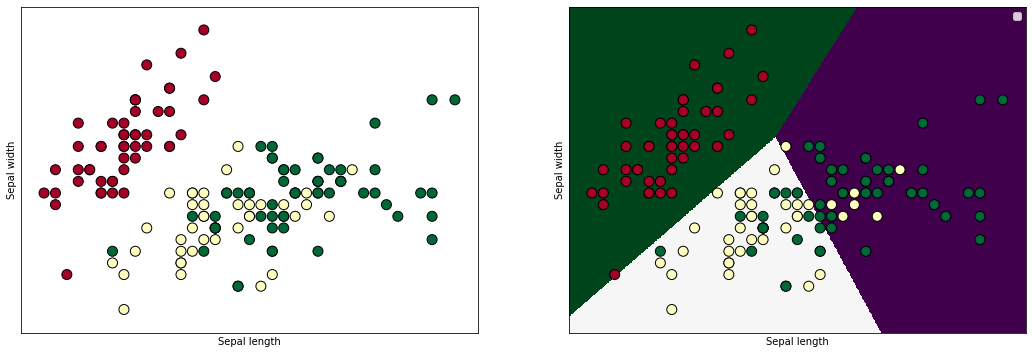

In [17]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max] times [y_min, y_max].
x_min, x_max = X[:, 0].min() - .2, X[:, 0].max() + .2
y_min, y_max = X[:, 1].min() - .2, X[:, 1].max() + .2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 600), np.linspace(y_min, y_max, 600))
Zs = logreg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

fig4 = plt.figure(3, figsize=(18, 6))
ax1, ax2 = fig4.add_subplot(121), fig4.add_subplot(122)

# Plot the dots with labels only
ax1.scatter(X[:, 0], X[:, 1], c=Y, s = 100, edgecolors='k')
ax1.set(xlabel = 'Sepal length', ylabel='Sepal width', xticks=(), yticks=(),
       xlim = ((xx.min(), xx.max())), ylim = ((yy.min(), yy.max())))

# Plot the decision boundaries and the partition areas
ax2.pcolormesh(xx, yy, Zs, cmap = plt.cm.PRGn_r)
ax2.scatter(X[:, 0], X[:, 1], c=Y, s = 100, edgecolors='k')
ax2.set(xlabel = 'Sepal length', ylabel='Sepal width', xticks=(), yticks=(),
       xlim = ((xx.min(), xx.max())), ylim = ((yy.min(), yy.max())))
plt.legend()
plt.show()

While one of the labels appear to be perfectly separable, the other two are more mixed

In [18]:
#which is also confirmed by low accuracy
correct=1.0*(Z==Y).sum()/len(Y)
print('Accuracy={}'.format(correct))

Accuracy=0.82


In [19]:
#see if taking all 4 available regressors could help
logreg = LogisticRegression()
logreg.fit(X, Y)
Z = logreg.predict(X)
correct=1.0*(Z==Y).sum()/len(Y)
print('Accuracy={}'.format(correct))

Accuracy=0.9733333333333334


## Find Manhattan based on 311 profiles of locations

In [20]:
#upload previous data we had on 311
data311 = pd.read_csv('aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [21]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')

In [22]:
zips = gpd.read_file("NY.geojson")
zips.head()

,zipcode,geometry
0,11372.0,"POLYGON Z ((-73.86942 40.74916 0.00000, -73.89..."
1,11004.0,"POLYGON Z ((-73.71068 40.75004 0.00000, -73.70..."
2,11040.0,"POLYGON Z ((-73.70098 40.73890 0.00000, -73.70..."
3,11426.0,"POLYGON Z ((-73.72270 40.75373 0.00000, -73.72..."
4,11365.0,"POLYGON Z ((-73.81089 40.72717 0.00000, -73.81..."


In [23]:
data311.shape

(19196, 3)

In [24]:
#take only NYC zip codes
# data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)]
data311 = data311[data311.Zip.isin(zips.zipcode)]
data311.shape

(18290, 3)

In [25]:
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)

In [26]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
83.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [27]:
data311.iloc[:, np.r_[0:5, 16:]]

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,...,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,Bike/Roller/Skate Chronic,Blocked Driveway,Boilers,Bottled Water,Bridge Condition,Broken Muni Meter
Zip,,,,,,,,,,,,,,,,,,,,,
83.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10001.0,0,1,90,0,0,0,1,90,0,0,...,20,36,1,1,2,51,2,1,0,498
10002.0,15,0,80,0,0,15,0,80,0,0,...,18,20,2,6,8,73,8,0,24,921
10003.0,15,1,143,0,2,15,1,143,0,2,...,24,13,2,2,14,69,16,0,0,1461
10004.0,0,0,15,0,0,0,0,15,0,0,...,3,1,0,1,1,8,3,0,0,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11691.0,48,0,6,0,0,48,0,6,0,0,...,5,2,2,0,0,141,17,0,0,51
11692.0,9,0,4,0,0,9,0,4,0,0,...,7,0,0,0,0,22,4,0,0,0
11693.0,5,2,8,0,0,5,2,8,0,0,...,13,2,0,0,1,41,6,0,2,2


In [28]:
# top 20 complaints by numbers
data311.sum().sort_values()[-20:].index

Index(['Sanitation Condition', 'Building/Use', 'Noise - Street/Sidewalk',
       'Noise - Commercial', 'Traffic Signal Condition', 'Sewer',
       'Dirty Conditions', 'Broken Muni Meter', 'ELECTRIC', 'Noise',
       'Illegal Parking', 'Street Light Condition', 'Water System', 'NONCONST',
       'Blocked Driveway', 'Street Condition', 'PAINT - PLASTER', 'PLUMBING',
       'GENERAL CONSTRUCTION', 'HEATING'],
      dtype='object', name='Complain')

In [29]:
#normalize and filter the data
Total311=data311.sum(axis=1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity

data311 = data311[data311.sum().sort_values()[-20:].index]
data311.head()

Complain,Sanitation Condition,Noise - Commercial,ELECTRIC,Building/Use,Traffic Signal Condition,Taxi Complaint,Dirty Conditions,Sewer,Broken Muni Meter,NONCONST,Noise,Illegal Parking,Blocked Driveway,PAINT - PLASTER,Water System,PLUMBING,Street Light Condition,Street Condition,GENERAL CONSTRUCTION,HEATING
Zip,,,,,,,,,,,,,,,,,,,,
10001.0,0.006882,0.045688,0.004832,0.004832,0.000146,0.103529,0.015815,0.010397,0.072924,0.009518,0.118758,0.025626,0.007468,0.011129,0.053595,0.011715,0.000586,0.062820,0.014204,0.042320
10002.0,0.007538,0.081767,0.010642,0.010642,0.028290,0.032636,0.012770,0.009046,0.081678,0.024299,0.057201,0.026960,0.006474,0.026871,0.028734,0.035651,0.026250,0.036183,0.031039,0.107662
10003.0,0.007454,0.054308,0.012246,0.005946,0.002041,0.053243,0.014376,0.010205,0.129648,0.019345,0.091667,0.019434,0.006123,0.025468,0.028219,0.031769,0.002840,0.050759,0.030970,0.095483
10004.0,0.005195,0.006494,0.000000,0.001948,0.062338,0.092208,0.007792,0.020779,0.079870,0.000000,0.112987,0.036364,0.005195,0.003247,0.024026,0.003247,0.060390,0.086364,0.000649,0.004545
10005.0,0.007671,0.017534,0.000000,0.003836,0.033973,0.062466,0.007671,0.009863,0.138082,0.003836,0.184658,0.033425,0.000548,0.000000,0.019726,0.002740,0.051507,0.087671,0.008219,0.005479


In [30]:
# create borough labels 
Z=np.array(data311.index)
manhattanInd=(Z>10000)&(Z<10300) #Manhattan
statenInd=(Z>=10300)&(Z<10400) #Staten Island
brooklynInd=(Z>=11000)&(Z<11300) #Brooklyn
queensInd=(Z>=11300)&(Z<11500) #Queens
bronxInd=(Z>=10400)&(Z<10500) #Bronx
#create an array of the same length as data311 index providing the borough number
D=Z*0
D[manhattanInd]=1
D[statenInd]=2
D[brooklynInd]=3
D[queensInd]=4
D[bronxInd]=5

In [31]:
#standardize the data
scaler311 = preprocessing.StandardScaler().fit(data311)
data311S=scaler311.transform(data311)  

In [32]:
data311S.shape

(182, 20)

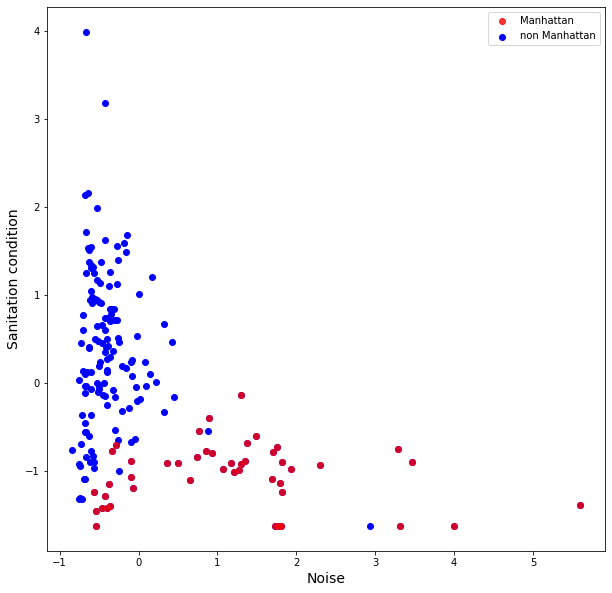

In [33]:
#visualize the zip code profiles by two complaint types - 'noise' and 'sanitation condition'
#mark Manhattan zip codes red

colors=('blue','red')
fig = plt.figure(figsize=(10,10))
# for d in range(0,2):
#     plt.plot(np.array(data311.loc[D==d,'Noise']), np.array(data311.loc[D==d, ]),
#         'o', color=colors[d], alpha=0.8, label=d)
plt.plot(np.array(data311S[D==1,10]), np.array(data311S[D==1, 0]),
        'o', color=colors[1], alpha=0.8, label='Manhattan')

plt.scatter(data311S[:,10],data311S[:,0], color=colors[0], label='non Manhattan')
plt.xlabel('Noise', fontsize=14)
plt.ylabel('Sanitation condition', fontsize=14)
plt.legend()

In [34]:
# Train logistic regression reporting the number of misclassified zip codes
logreg = LogisticRegression(C=1) #C is a regularization constant (will discuss regularization later in the class; 1 is the default value - going forward we'll skip it meaning that we are using the default setting)
Y=1.0*(D==1)
logreg.fit(data311S[:, [10,0]], Y)
Z = logreg.predict(data311S[:, [10,0]])

(-2.0, 5.0)

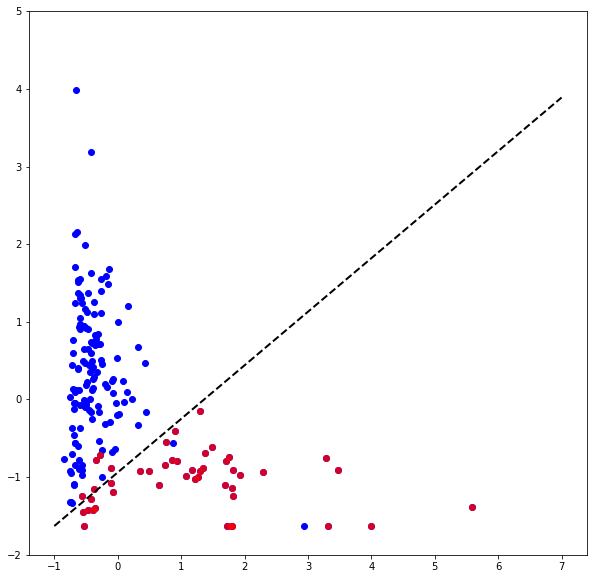

In [35]:
# visualize the zip code prifiles by the two complaint types
# mark Manhattan zip codes red
colors=('blue','red')
fig = plt.figure(figsize=(10,10))
# for d in range(0,2):
#     plt.plot(np.array(data311.loc[D==d,'Noise']), np.array(data311.loc[D==d, ]),
#         'o', color=colors[d], alpha=0.8, label=d)
plt.plot(np.array(data311S[D==1,10]), np.array(data311S[D==1, 0]),
        'o', color=colors[1], alpha=0.8, label='Manhattan')

plt.scatter(data311S[:,10],data311S[:,0], color=colors[0], label='non Manhattan')

xplot = np.linspace(-1,7,200) ## returns evenly spaced numbers
yplot = -(logreg.intercept_[0] + logreg.coef_[0][0]*xplot)/logreg.coef_[0][1]
plt.plot(xplot, yplot, 'k--', lw = 2)
plt.ylim(-2, 5)

In [36]:
print('LOGISTIC REGRESSION \nErrors={0}'.format(sum(Z!=Y)))
print_confusion_matrix(Z, Y)

LOGISTIC REGRESSION 
Errors=7
Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                 134                   5
Actual Positive                   2                  41


In [37]:
#train support vector machines reporting the number of misclassified zip codes
svmodel = svm.SVC(kernel='linear') #default kernel is linear, meaning that we're looking for linear decision boundary; SVM can also look for nonlinear separation 
svmodel.fit(data311S[:, [10,0]], Y)
Z2 = svmodel.predict(data311S[:, [10,0]])
print('SVM (Linear kernel) \nErrors={0}'.format(sum(Z!=Y)))
print_confusion_matrix(Z2, Y)

SVM (Linear kernel) 
Errors=7
Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                 134                   4
Actual Positive                   2                  42


In [38]:
#train non-linear support vector machines with Gausian kernel reporting the number of misclassified zip codes
svmodel = svm.SVC(kernel='rbf') #Gausian kernel
svmodel.fit(data311S[:, [10,0]], Y)
Z2 = svmodel.predict(data311S[:, [10,0]])
print('SVM (Gaussian Kernel) \nErrors={0}'.format(sum(Z!=Y)))
print_confusion_matrix(Z2, Y)

SVM (Gaussian Kernel) 
Errors=7
Confusion Matrix:
                  Predicted Negative  Predicted Positive
Actual Negative                 133                   2
Actual Positive                   3                  44


In [39]:
colors=['green','blue','red','yellow','magenta','cyan']
def plot_on_map(gdf,Y): #take geopandas dataframe gdf with zip code shapefiles and the dictionary mapping zip codes to clusters
    #visualize zip codes using clusters for picking colors        
    f, ax = plt.subplots(1, figsize=(12, 12))     
    for c in range(max(Y.values())+1): #for each cluster
        gdf.loc[gdf.zipcode.map(Y)==c].plot(axes=ax, color=colors[c]) #visualize zip codes which belong to it using cluster color

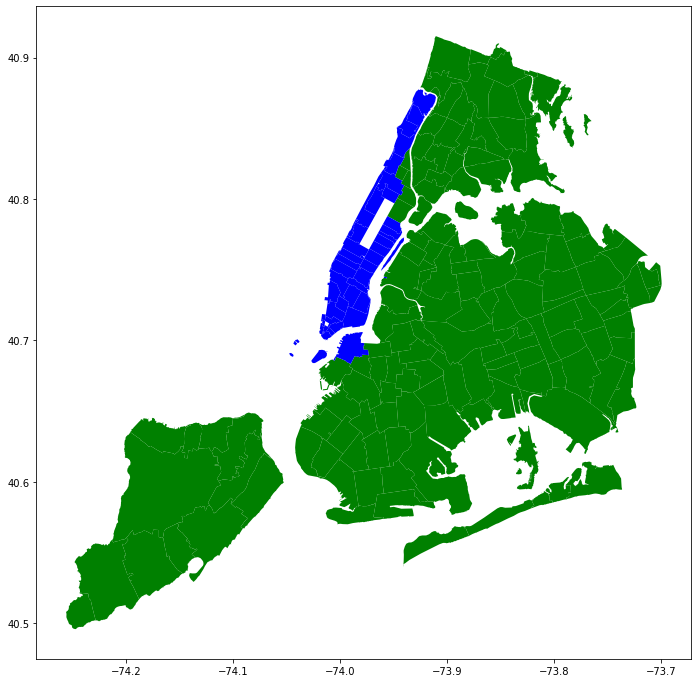

In [40]:
plot_on_map(zips,{data311.index[i]:int(Z[i]) for i in range(len(Z))})

#### Multiclass classification for boroughs.

In [41]:
# Logistic regression can be also trained for multi-class classification
logreg = LogisticRegression()
Y=D
X=data311S[:,:]
logreg.fit(X, Y)
M = logreg.predict(X)
#report accuracy
1.0*sum(M==D)/len(M)

0.9395604395604396

In [42]:
#certainty of classification
pd.DataFrame(logreg.predict_proba(X)).head()

,0,1,2,3,4,5
0,0.000006,0.999702,0.000015,0.000266,0.000008,2.257047e-06
1,0.000105,0.978415,0.000016,0.021189,0.000270,4.590650e-06
2,0.000005,0.999487,0.000004,0.000460,0.000038,5.583828e-06
3,0.003531,0.653367,0.000543,0.311392,0.031165,3.400671e-06
4,0.000020,0.994762,0.000027,0.004912,0.000278,5.207893e-07


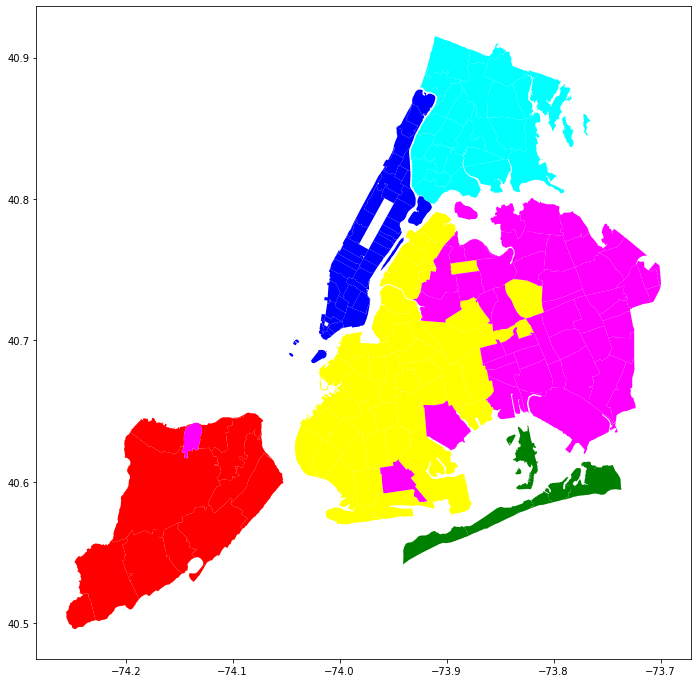

In [43]:
plot_on_map(zips,{data311.index[i]:int(M[i]) for i in range(len(Z))})

## MNIST handwritten digit classification

In [44]:
from sklearn.datasets import fetch_openml #function to load sample datasets

In [48]:
mnist = fetch_openml('mnist_784') #takes few seconds to load

# There are 70,000 images (28 by 28 images for a dimensionality of 784)
mnist.data.shape

(70000, 784)

In [49]:
# number of labels
mnist.target.shape

(70000,)

In [56]:
mnist.data[::5]

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# separate data into features and targets, also take only 1/5th of the data as the dataset is big and computation is slow otherwise

features = mnist.data[::5, :]
targets = mnist.target[::5].astype(int)

print(features.shape, targets.shape)

(14000, 784) (14000,)


In [69]:
#example of the data segment
features.iloc[:10,430:440]

,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440
0,0.0,0.0,0.0,0.0,45.0,186.0,253.0,253.0,150.0,27.0
5,227.0,252.0,243.0,228.0,170.0,242.0,252.0,252.0,231.0,117.0
10,0.0,0.0,73.0,89.0,89.0,93.0,240.0,254.0,171.0,0.0
15,0.0,0.0,0.0,0.0,77.0,247.0,252.0,248.0,106.0,0.0
20,252.0,252.0,252.0,253.0,252.0,252.0,252.0,252.0,252.0,252.0
25,253.0,253.0,253.0,192.0,105.0,0.0,0.0,0.0,0.0,0.0
30,42.0,61.0,61.0,61.0,61.0,83.0,176.0,79.0,110.0,247.0
35,255.0,114.0,0.0,0.0,0.0,141.0,255.0,29.0,0.0,0.0
40,0.0,0.0,24.0,253.0,253.0,176.0,0.0,0.0,0.0,0.0
45,252.0,252.0,252.0,200.0,22.0,11.0,198.0,231.0,41.0,0.0


In [60]:
targets[:10] #example of the labels

0     5
5     2
10    3
15    7
20    4
25    2
30    3
35    5
40    1
45    9
Name: class, dtype: int64

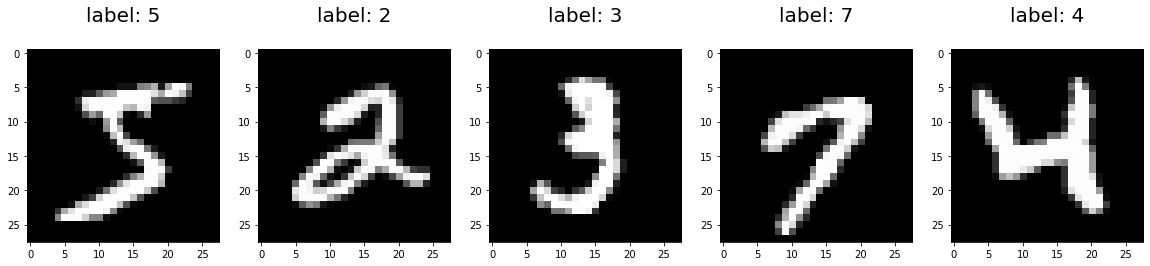

In [70]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(features[0:5].values, targets[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('label: %i\n' % label, fontsize = 20)

In [71]:
# train logistic regression model #takes up to 5-10 minutes to execute

logreg = LogisticRegression()

Y=targets
X=features
logreg.fit(X, Y)

LogisticRegression()

In [79]:
# predicting label of the first image

logreg.predict(features.values[0].reshape(1,-1))

array([5])

In [80]:
# make predictions for entire dataset

predictions = logreg.predict(features)
predictions

array([5, 2, 3, ..., 2, 7, 2])

In [81]:
# accuracy of predictions

sum(predictions == targets)/len(targets)

0.9612857142857143

In [92]:
targets

0        5
5        2
10       3
15       7
20       4
        ..
69975    3
69980    2
69985    2
69990    7
69995    2
Name: class, Length: 14000, dtype: int64

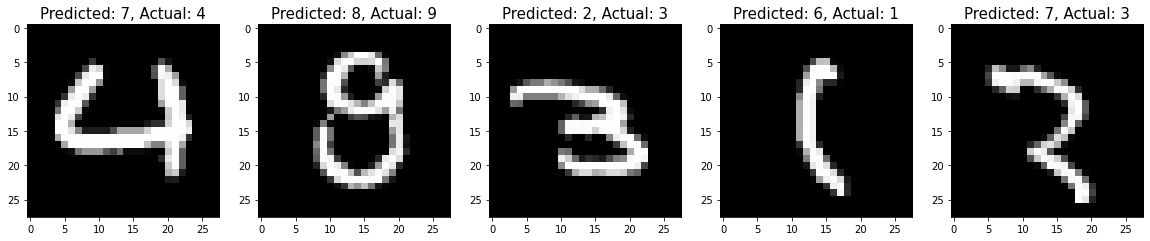

In [93]:
# Getting the misclassified images’ index and displaying them

index = 0
misclassifiedIndexes = []
for label, predict in zip(targets, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
        

plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(features.values[badIndex], (28,28)), cmap=plt.cm.gray)
    plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], targets.values[badIndex]), fontsize = 15)

In [94]:
# confusion matrix for the predictions

cm = metrics.confusion_matrix(targets, predictions)
cm

array([[1361,    0,    0,    1,    1,    3,    2,    1,    4,    0],
       [   0, 1556,    4,    3,    1,    2,    1,    1,    6,    1],
       [   5,    6, 1333,   14,    8,    3,    8,    8,   18,    4],
       [   2,    1,   20, 1469,    0,   20,    2,    7,   17,    3],
       [   0,    1,    1,    2, 1263,    1,    5,    5,   10,   17],
       [   4,    2,    7,   27,    6, 1162,    9,    1,   34,   12],
       [   2,    0,    9,    0,    1,    7, 1357,    0,    2,    1],
       [   0,    2,    8,    1,    7,    1,    1, 1404,    4,   27],
       [   2,    7,    9,   17,    2,   19,    5,    3, 1299,    5],
       [   4,    3,    0,    8,   25,    5,    1,   26,    7, 1254]])

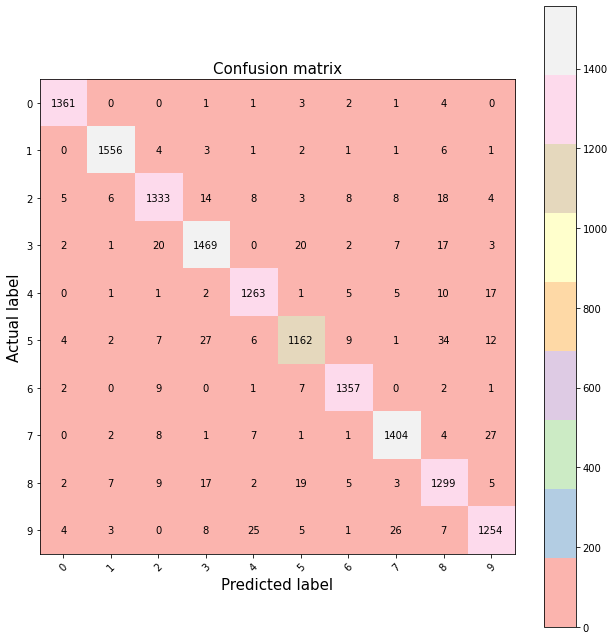

In [95]:
# visulaizing confusion matrix

plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], rotation=45, size = 10)
plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

plt.tight_layout()

### Evaluating model by out of sample performance

### Splitting into train-test set

Splitting the data into training and test set can help understanding whether the model's performance generalize beyond the dataset it got originally trained on (i.e. does not overfit the training data learning too many dataset-specific patterns from it). Models sometimes can have high accuracy over the training set and low accuracy over the test set which indicates overfitting. Generally, what matters is the out-of-sample (test set) prediction performance. 

In [96]:
# sklearn has in-built functions for the traing-test set split

X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.75) #use random 75% of the data for training, rest - for testing

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10500, 784) (3500, 784) (10500,) (3500,)


In [97]:
# train model on train set, calculate accuracy on test set #takes up to 5 min to run

logreg = LogisticRegression()

Y = y_train
X = X_train
logreg.fit(X, Y)

pred = logreg.predict(X_test)

sum(pred == y_test)/len(y_test)

0.88

## Homework
Example - learning the probability of school admission based on two exams

In [98]:
admission = pd.read_csv('admission.csv')  
admission.head()

,exam1,exam2,admit
0,34,78,0
1,30,43,0
2,35,72,0
3,60,86,1
4,79,75,1


In [99]:
admission.shape

(100, 3)

### Q1. Run the logistic classifier and SVM for the binary classification of admitted/not admitted student records. Report the model accuracy

### Q2. Visualize decision boundary for either model

### Q3. Calculate the confusion matrix for each model performance

### Q4. Predict the probability of acceptance for a student with exam scores 75 and 53 according to logistic regression

### Q5. Train the logistic classifier again but now using only the first 75 records as the training set. Apply the model to the last 25 records and assess the accuracy for those (out-of-sample test)  